Ngưỡng phân loại (λ): 176.25


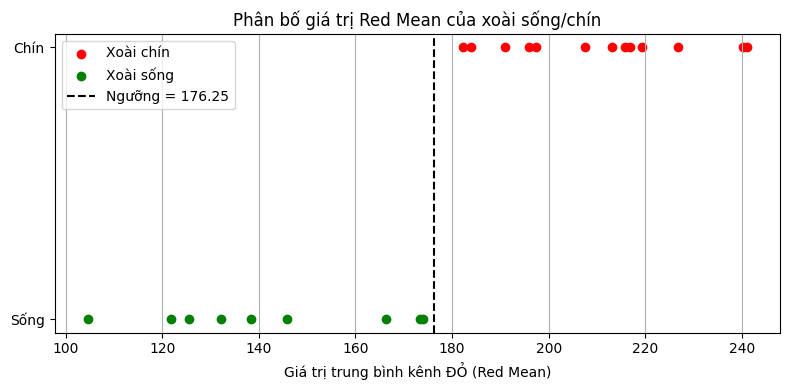

In [1]:
from PIL import Image          # Xử lý ảnh (đọc, convert RGB)
import numpy as np             # Xử lý ma trận, số liệu
import matplotlib.pyplot as plt # Vẽ biểu đồ
import os                      # Làm việc với file & folder

# === Đường dẫn dataset (ảnh xoài đã tách nền) ===
base_dir = "/media/pphong/D:/ML & DL/ML/pred_mango/image_tachnen"

# Lưu giá trị trung bình kênh đỏ theo nhãn
red_means = {"chin": [], "song": []}

# === TÍNH MEAN CHO TỪNG ẢNH ===
for label in ["chin", "song"]:                         # Duyệt qua 2 thư mục: chin và song
    folder_path = os.path.join(base_dir, label)        # Đường dẫn thư mục
    for fname in os.listdir(folder_path):              # Duyệt qua từng ảnh
        if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue                                   # Bỏ qua nếu không phải ảnh

        # Đọc ảnh và chuyển sang RGB
        img = Image.open(os.path.join(folder_path, fname)).convert("RGB")
        img_np = np.array(img)                         # Chuyển sang mảng numpy

        # Mask để bỏ nền đen (chỉ giữ vùng có xoài)
        mask = np.any(img_np > [0, 0, 0], axis=-1)

        # Lấy giá trị kênh đỏ trong vùng xoài
        red_values = img_np[:, :, 0][mask]

        if red_values.size > 0:                        # Nếu vùng xoài có dữ liệu
            red_mean = np.mean(red_values)             # Trung bình kênh đỏ
            red_means[label].append(red_mean)          # Lưu theo nhãn (chín / sống)

# === TÍNH NGƯỠNG PHÂN LOẠI ===
mean_chin = np.mean(red_means["chin"])                 # Trung bình xoài chín
mean_song = np.mean(red_means["song"])                 # Trung bình xoài sống
lamda = (mean_chin + mean_song) / 2                    # Ngưỡng trung bình

print(f"Ngưỡng phân loại (λ): {lamda:.2f}")

# === VẼ BIỂU ĐỒ ===
plt.figure(figsize=(8,4))

# Xoài chín (màu đỏ, y=1)
plt.scatter(red_means["chin"], [1]*len(red_means["chin"]),
            color="red", label="Xoài chín")

# Xoài sống (màu xanh lá, y=0)
plt.scatter(red_means["song"], [0]*len(red_means["song"]),
            color="green", label="Xoài sống")

# Vẽ đường ngưỡng
plt.axvline(x=lamda, color='black', linestyle='--', label=f'Ngưỡng = {lamda:.2f}')

# Cấu hình hiển thị
plt.yticks([0,1], ["Sống","Chín"])
plt.xlabel("Giá trị trung bình kênh ĐỎ (Red Mean)")
plt.title("Phân bố giá trị Red Mean của xoài sống/chín")
plt.legend()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


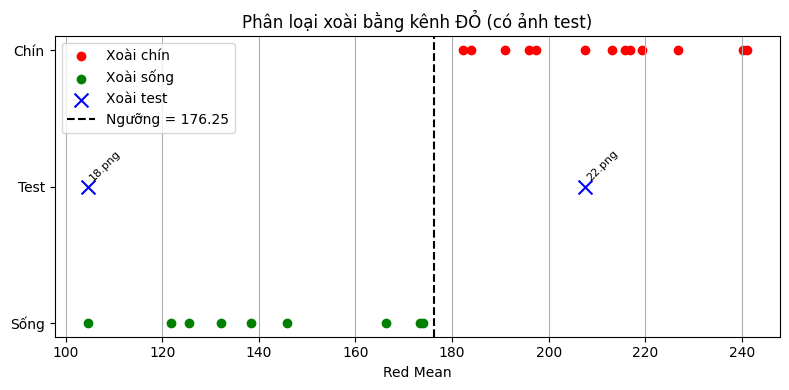

18.png: Red Mean = 104.55 -> Dự đoán = song
22.png: Red Mean = 207.52 -> Dự đoán = chin


In [2]:
# === TEST ẢNH CHƯA GÁN NHÃN ===
test_dir = "/media/pphong/D:/ML & DL/ML/pred_mango/image_test"  
# Đường dẫn thư mục chứa ảnh test (chưa gán nhãn)

test_red_means = []   # Lưu giá trị red mean của ảnh test
test_labels = []      # Lưu kết quả phân loại (chín/sống)
test_files = []       # Lưu tên file test

for fname in os.listdir(test_dir):                       # Duyệt qua từng file trong thư mục test
    if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue                                         # Nếu không phải ảnh thì bỏ qua
    
    # Đọc ảnh test
    img = Image.open(os.path.join(test_dir, fname)).convert("RGB")  # Mở ảnh & chuyển sang RGB
    img_np = np.array(img)                                           # Đưa về numpy array

    # Bỏ nền đen
    mask = np.any(img_np > [0,0,0], axis=-1)              # Giữ lại pixel khác [0,0,0]
    red_values = img_np[:,:,0][mask]                      # Lấy toàn bộ giá trị kênh đỏ trong vùng xoài

    if red_values.size > 0:                               # Nếu có pixel xoài
        rmean = np.mean(red_values)                       # Tính trung bình kênh đỏ
        test_red_means.append(rmean)                      # Lưu giá trị red mean
        test_files.append(fname)                          # Lưu tên file

        # So sánh với ngưỡng để phân loại
        if rmean >= lamda:                                # Nếu red_mean lớn hơn ngưỡng
            test_labels.append("chin")                    # Dự đoán xoài chín
        else:
            test_labels.append("song")                    # Ngược lại → xoài sống

# === VẼ BIỂU ĐỒ CÙNG VỚI TEST ===
plt.figure(figsize=(8,4))                                 # Tạo figure 8x4

# Dữ liệu training
plt.scatter(red_means["chin"], [1]*len(red_means["chin"]),  # Vẽ xoài chín (y=1, chấm đỏ)
            color="red", label="Xoài chín")
plt.scatter(red_means["song"], [0]*len(red_means["song"]),  # Vẽ xoài sống (y=0, chấm xanh)
            color="green", label="Xoài sống")

# Dữ liệu test (hiện ở giữa trục y=0.5)
for i, rmean in enumerate(test_red_means):                # Duyệt qua từng ảnh test
    plt.scatter(rmean, 0.5, color="blue", marker="x", s=100, # Vẽ dấu X xanh dương ở y=0.5
                label="Xoài test" if i==0 else "")           # Đặt label 1 lần cho legend
    plt.text(rmean, 0.52, test_files[i], fontsize=8, rotation=45)  # Ghi tên file cạnh điểm test

# Vẽ ngưỡng λ
plt.axvline(x=lamda, color='black', linestyle='--', label=f'Ngưỡng = {lamda:.2f}')  
# Vẽ đường thẳng đứng chia chín/sống

# Tùy chỉnh trục
plt.yticks([0,0.5,1], ["Sống","Test","Chín"])             # Đặt nhãn cho trục Y
plt.xlabel("Red Mean")                                    # Nhãn trục X
plt.title("Phân loại xoài bằng kênh ĐỎ (có ảnh test)")    # Tiêu đề biểu đồ
plt.legend()                                              # Hiển thị chú thích
plt.grid(True, axis="x")                                  # Bật lưới theo trục X
plt.tight_layout()                                        # Canh layout gọn gàng
plt.show()                                                # Hiển thị biểu đồ

# In kết quả phân loại test
for fname, rmean, label in zip(test_files, test_red_means, test_labels):
    print(f"{fname}: Red Mean = {rmean:.2f} -> Dự đoán = {label}")
# In ra: tên file, giá trị Red Mean, và dự đoán chín/sống
